# Single nucleotide variants (SNVs)

**Author**: Katarina Braun 


## Overview

This script maps fasta files (contains the consensus sequence generated from the ARTIC analysis pipeline) to the Wuhan/1 reference (MT039887), generates an alignment file (bam), sorts the bam (sam), generates a pileup file, and calls variants (any position that differs from the reference) using Varscan. The resulting VCF files contain consensus SNVs only. 

This script cleans up the VCF files and saves each VCF as a new, smaller CSV. 

This script also generates two figures:
1. Consensus SNVs vs # of sequences figure. 
2. Number of sequences within age bins 

## Input: 

Consensus fasta files: 

`data_raw/UWHC/*.fasta`
    - 122 files 
`data_raw/MHD/*.fasta`
    - 125 files


## Output: 

Consensus SNV output files: 

`data_derived/UWHC/VCFs/*.vcfs`
    - 122 files
`data_derived/UWHC/VCFs/*.vcfs`
    - 125 files 

Figures:  
1. `figures/consensus_SNV_differences.pdf` 
2. `figures/SNVs_vs_age.pdf`
3. `figures/SNVs-per-age-bins.pdf`
 



## import modules and dependencies 

In [362]:
import pandas as pd
import glob, os
import shutil as sh
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from pandas.plotting import table
from statistics import mean
import statistics

## map reads, modify alignment file, call consensus SNVs


In [44]:
%%bash 

# UWHC samples, this takes ~10 mins to run 

for file in $(ls ../data_raw/UWHC/*.fasta)
do 
    bbmap.sh in=$file out=$file.bam ref=ref.fa #map to Wuhan reference
    samtools sort $file.bam -o $file.bam # sort the bam 
    samtools mpileup -f ref.fa $file.bam > $file.pileup # generate a pileup file
    java -jar VarScan.jar pileup2snp $file.pileup --min-coverage 1 --min-reads2 1 > $file.vcf
done

##

Max memory cannot be determined.  Attempting to use 3200 MB.
If this fails, please add the -Xmx flag (e.g. -Xmx24g) to your command, 
or run this program qsubbed or from a qlogin session on Genepool, or set ulimit to an appropriate value.
java -Djava.library.path=/Users/katbraun/anaconda3/opt/bbmap-38.22-1/jni/ -ea -Xmx3200m -cp /Users/katbraun/anaconda3/opt/bbmap-38.22-1/current/ align2.BBMap build=1 overwrite=true fastareadlen=500 in=../data_raw/UWHC/USA_WI-UW-02_2020.fasta out=../data_raw/UWHC/USA_WI-UW-02_2020.fasta.bam ref=ref.fa
Executing align2.BBMap [build=1, overwrite=true, fastareadlen=500, in=../data_raw/UWHC/USA_WI-UW-02_2020.fasta, out=../data_raw/UWHC/USA_WI-UW-02_2020.fasta.bam, ref=ref.fa]
Version 38.22

Retaining first best site only for ambiguous mappings.
NOTE:	Ignoring reference file because it already appears to have been processed.
NOTE:	If you wish to regenerate the index, please manually delete ref/genome/1/summary.txt
Set genome to 1

Loaded Reference:	0.023 se

In [45]:
%%bash 

# MHD samples, this takes ~10 mins to run 

for file in $(ls ../data_raw/MHD/*.fasta)
do 
    bbmap.sh in=$file out=$file.bam ref=ref.fa #map to Wuhan reference
    samtools sort $file.bam -o $file.bam # sort the bam 
    samtools mpileup -f ref.fa $file.bam > $file.pileup # generate a pileup file
    java -jar VarScan.jar pileup2snp $file.pileup --min-coverage 1 --min-reads2 1 > $file.vcf
done

##

Max memory cannot be determined.  Attempting to use 3200 MB.
If this fails, please add the -Xmx flag (e.g. -Xmx24g) to your command, 
or run this program qsubbed or from a qlogin session on Genepool, or set ulimit to an appropriate value.
java -Djava.library.path=/Users/katbraun/anaconda3/opt/bbmap-38.22-1/jni/ -ea -Xmx3200m -cp /Users/katbraun/anaconda3/opt/bbmap-38.22-1/current/ align2.BBMap build=1 overwrite=true fastareadlen=500 in=../data_raw/MHD/USA_WI-UW-156_2020.fasta out=../data_raw/MHD/USA_WI-UW-156_2020.fasta.bam ref=ref.fa
Executing align2.BBMap [build=1, overwrite=true, fastareadlen=500, in=../data_raw/MHD/USA_WI-UW-156_2020.fasta, out=../data_raw/MHD/USA_WI-UW-156_2020.fasta.bam, ref=ref.fa]
Version 38.22

Retaining first best site only for ambiguous mappings.
NOTE:	Ignoring reference file because it already appears to have been processed.
NOTE:	If you wish to regenerate the index, please manually delete ref/genome/1/summary.txt
Set genome to 1

Loaded Reference:	0.025 se

In [46]:
# move *.vcf files from data_raw to data_derived 
# UWHC

root_path = "../data_raw/Dane/"
dest_path = "../data_derived/Dane/VCFs/"

for dirpath, dnames, fnames in os.walk(root_path):    
    for f in fnames:
        if f.endswith(".vcf"):
            source_file_path =  os.path.join(dirpath, f)
            dest_file_path   =  os.path.join(dest_path, f)
            sh.copyfile(source_file_path, dest_file_path)

In [47]:
# move *.vcf files from data_raw to data_derived 
# MHD

root_path = "../data_raw/MKE/"
dest_path = "../data_derived/MKE/VCFs/"

for dirpath, dnames, fnames in os.walk(root_path):    
    for f in fnames:
        if f.endswith(".vcf"):
            source_file_path =  os.path.join(dirpath, f)
            dest_file_path   =  os.path.join(dest_path, f)
            sh.copyfile(source_file_path, dest_file_path)

## cleanup data_raw directories

Get rid of *bam* and *pileup* files generated above. 

In [48]:
# UWHC cleanup 

dir_name = "../data_raw/Dane/"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".bam"):
        os.remove(os.path.join(dir_name, item))
        
for item in test:
    if item.endswith(".pileup"):
        os.remove(os.path.join(dir_name, item))
        
for item in test:
    if item.endswith(".vcf"):
        os.remove(os.path.join(dir_name, item))

In [49]:
# MHD cleanup 

dir_name = "../data_raw/MKE/"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".bam"):
        os.remove(os.path.join(dir_name, item))
        
for item in test:
    if item.endswith(".pileup"):
        os.remove(os.path.join(dir_name, item))
        
for item in test:
    if item.endswith(".vcf"):
        os.remove(os.path.join(dir_name, item))

## load VCF files into dataframes

In [108]:
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.vcf')]
    list_of_DFs = []
    for file in filelist: 
#         print(file)
        DF = path + '/' + file + '.vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        file['sample'] = DF
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)


In [109]:
# there are two MDH samples (270 and 339) that don't have any consensus SNVs -- these are identical to Wuhan/1
# I am going to write a NaN-only line into the VCFs so the cleaning functions to spit out errors 

with open('../data_derived/MKE/VCFs/USA_WI-UW-270_2020.fasta.vcf', 'a') as file:
    file.write('NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN')
    
with open('../data_derived/MKE/VCFs/USA_WI-UW-339_2020.fasta.vcf', 'a') as file:
    file.write('NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN')

In [123]:
# generate a list of dataframes

list_of_Dane_DFs = load_dataframes('../data_derived/Dane/VCFs')

list_of_MKE_DFs = load_dataframes('../data_derived/MKE/VCFs')

['USA_WI-UW-356_2020.fasta', 'USA_WI-UW-28_2020.fasta', 'USA_WI-UW-59_2020.fasta', 'USA_WI-UW-44_2020.fasta', 'USA_WI-UW-51_2020.fasta', 'USA_WI-UW-35_2020.fasta', 'USA_WI-UW-116_2020.fasta', 'USA_WI-UW-103_2020.fasta', 'USA_WI-UW-351_2020.fasta', 'USA_WI-UW-119_2020.fasta', 'USA_WI-UW-56_2020.fasta', 'USA_WI-UW-43_2020.fasta', 'USA_WI-UW-359_2020.fasta', 'USA_WI-UW-111_2020.fasta', 'USA_WI-UW-32_2020.fasta', 'USA_WI-UW-27_2020.fasta', 'USA_WI-UW-42_2020.fasta', 'USA_WI-UW-26_2020.fasta', 'USA_WI-UW-33_2020.fasta', 'USA_WI-UW-110_2020.fasta', 'USA_WI-UW-105_2020.fasta', 'USA_WI-UW-50_2020.fasta', 'USA_WI-UW-45_2020.fasta', 'USA_WI-UW-102_2020.fasta', 'USA_WI-UW-117_2020.fasta', 'USA_WI-UW-34_2020.fasta', 'USA_WI-UW-29_2020.fasta', 'USA_WI-UW-58_2020.fasta', 'USA_WI-UW-100_2020.fasta', 'USA_WI-UW-115_2020.fasta', 'USA_WI-UW-52_2020.fasta', 'USA_WI-UW-108_2020.fasta', 'USA_WI-UW-112_2020.fasta', 'USA_WI-UW-107_2020.fasta', 'USA_WI-UW-259_2020.fasta', 'USA_WI-UW-31_2020.fasta', 'USA_WI-UW

In [124]:
# clean up the VCF files and save as CSV files 

def clean_Dane_dataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    for DF in list_of_DFs:
        DF = DF[['sample', 'Position', 'Ref', 'Cons']]
        DF['sample'] = DF['sample'].map(lambda x: x.lstrip('../data_derived/Dane/VCFs/'))
        DF['sample'] = DF['sample'].map(lambda x: x.rstrip('.fasta.vcf'))
        DF['sample'] = DF['sample'].map(lambda x: x.lstrip('SA_'))
        sample = DF['sample'].values[0]
        DF.to_csv(path + 'cleaned/' + sample + '-cleaned.csv', sep='\t')
        
def clean_MKE_dataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    for DF in list_of_DFs:
        DF = DF[['sample', 'Position', 'Ref', 'Cons']]
        DF['sample'] = DF['sample'].map(lambda x: x.lstrip('../data_derived/MKE/VCFs/'))
        DF['sample'] = DF['sample'].map(lambda x: x.rstrip('.fasta.vcf'))
        DF['sample'] = DF['sample'].map(lambda x: x.lstrip('USA_'))
        sample = DF['sample'].values[0]
        DF.to_csv(path + 'cleaned/' + sample + '-cleaned.csv', sep='\t')

In [125]:
# clean up all of the dataframes and save to new CSV files 

clean_Dane_dataframes('../data_derived/Dane/', list_of_Dane_DFs) # Dane County

clean_MKE_dataframes('../data_derived/MKE/', list_of_MKE_DFs) # Milwaukee County 

/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [126]:
# check to make sure there is the correct number of cleaned CSV files in each cleaned directory 

path, dirs, files = next(os.walk("../data_derived/Dane/cleaned"))
Dane_len = len(files)

path, dirs, files = next(os.walk("../data_derived/MKE/cleaned"))
MKE_len = len(files)

print(Dane_len) # should be 122
print(MKE_len) # should be 125

122
125


In [278]:
# merge all SNVs into a single dataframe

Dane_all = pd.concat([pd.read_csv(f, sep='\t') for f in glob.glob("../data_derived/Dane/cleaned/*.csv")], ignore_index=True)
Dane_all = Dane_all[['sample', 'Position']]

MKE_all = pd.concat([pd.read_csv(f, sep='\t') for f in glob.glob("../data_derived/MKE/cleaned/*.csv")], ignore_index=True)
MKE_all = MKE_all[['sample', 'Position']]



/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [229]:
MKEannots = pd.concat([pd.read_csv(f, sep='\t') for f in glob.glob("../data_derived/MKE/cleaned/*.csv")], ignore_index=True)

MKEannots = MKEannots.drop_duplicates(subset='Position', keep="first")

MKEannots = MKEannots[['Cons', 'Position', 'Ref', 'sample']]

MKEannots.to_csv("/Users/katbraun/Desktop/MKEannots.csv")


/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [245]:
# print the total number of SNVs as well as the total number of unique SNVs in each catchment area 

Dane_unique = Dane_all.drop_duplicates(subset='Position', keep="first")
MKE_unique = MKE_all.drop_duplicates(subset='Position', keep="first")

print("Total # of Dane SNVs:", len(Dane_all)) # total number of UWHC SNVs 
print("Total # of MKE SNVs:", len(MKE_all)) # total number of MHD SNVs

print("# of unique Dane SNVs:", len(Dane_unique)) # total number of UWHC SNVs 
print("# of unique MKE SNVs:", len(MKE_unique)) # total number of MHD SNVs

#

Total # of Dane SNVs: 933
Total # of MKE SNVs: 627
# of unique Dane SNVs: 155
# of unique MKE SNVs: 148


## load metadata

In [246]:
metadata = pd.read_csv('../data_raw/metadata.csv')

metadata = metadata[['Position', 'Annotations']]

metadata_dict = dict(zip(metadata.Position, metadata.Annotations))

In [247]:
temp = Dane_all.groupby('Position')['sample'].apply(','.join)

Dane_group = pd.DataFrame(temp)

Dane_group = Dane_group['sample'].str.split(pat=",", expand=True)

Dane_group['Sample_count'] = Dane_group.apply(lambda x: x.count(), axis=1)

Dane_group = Dane_group[['Sample_count']]

Dane_group = Dane_group.reset_index()

Dane_group['Annotation']= Dane_group['Position'].map(metadata_dict)

# Dane_group

#

In [248]:
temp1 = MKE_all.groupby('Position')['sample'].apply(','.join)

MKE_group = pd.DataFrame(temp1)

MKE_group = MKE_group['sample'].str.split(pat=",", expand=True)

MKE_group['Sample_count'] = MKE_group.apply(lambda x: x.count(), axis=1)

MKE_group = MKE_group[['Sample_count']]

MKE_group = MKE_group.reset_index()

MKE_group['Annotation']= MKE_group['Position'].map(metadata_dict)

#

In [249]:
# split dataframe into synonymous + intergenic (open datapoints)

Dane_group_syn_temp = Dane_group.loc[Dane_group.Annotation=='synonymous']

Dane_group_intergenic = Dane_group.loc[Dane_group.Annotation=='intergenic']

Dane_frames_syn = [Dane_group_syn_temp, Dane_group_intergenic]

Dane_group_syn = pd.concat(Dane_frames_syn)

Dane_group_syn = Dane_group_syn.sort_values('Position')

# split dataframe into nonsynonymous (closed datapoints)

Dane_group_nonsyn = Dane_group.loc[Dane_group.Annotation=='nonsynonymous']

Dane_group_nonsyn = Dane_group_nonsyn.sort_values('Position')

#

In [250]:
# split dataframe into synonymous + intergenic (open datapoints)

MKE_group_syn_temp = MKE_group.loc[MKE_group.Annotation=='synonymous']

MKE_group_intergenic = MKE_group.loc[MKE_group.Annotation=='intergenic']

MKE_frames_syn = [MKE_group_syn_temp, MKE_group_intergenic]

MKE_group_syn = pd.concat(MKE_frames_syn)

MKE_group_syn = MKE_group_syn.sort_values('Position')

# split dataframe into nonsynonymous (closed datapoints)

MKE_group_nonsyn = MKE_group.loc[MKE_group.Annotation=='nonsynonymous']

MKE_group_nonsyn = MKE_group_nonsyn.sort_values('Position')


#

In [256]:
Dane_syn = len(Dane_group_syn)
Dane_nonsyn = len(Dane_group_nonsyn)

MKE_syn = len(MKE_group_syn)
MKE_nonsyn = len(MKE_group_nonsyn)

Dane_ratio = Dane_nonsyn / Dane_syn
MKE_ratio = MKE_nonsyn / MKE_syn

print("# of synonymous SNVs in Dane county is ", len(Dane_group_syn))
print("# of nonsynonymous SNVs in Dane county is ", len(Dane_group_nonsyn))

print("# of synonymous SNVs in MKE county is ", len(MKE_group_syn))
print("# of nonsynonymous SNVs in MKE county is ", len(MKE_group_nonsyn))

print("ratio of nonsyn/syn in Dane county is ", Dane_ratio)
print("ratio of nonsyn/syn in MKE county is ", MKE_ratio)

# of synonymous SNVs in Dane county is  73
# of nonsynonymous SNVs in Dane county is  82
# of synonymous SNVs in MKE county is  53
# of nonsynonymous SNVs in MKE county is  94
ratio of nonsyn/syn in Dane county is  1.1232876712328768
ratio of nonsyn/syn in MKE county is  1.7735849056603774


/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


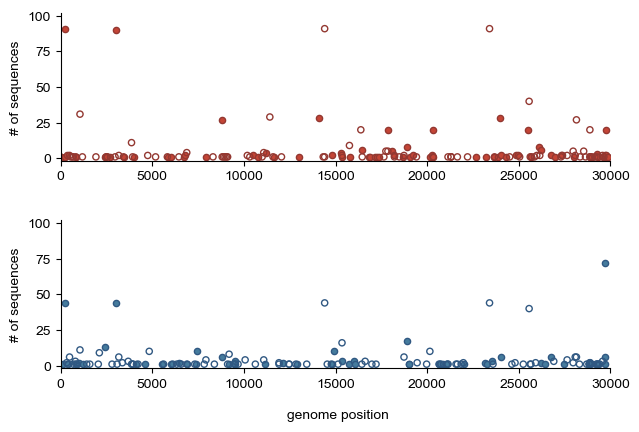

In [252]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(12,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(4, 12)

ax1 = fig.add_subplot(gs[1,0:6])
ax2 = fig.add_subplot(gs[2,0:6])

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax1.set_xlabel('', fontname='Arial', fontsize=10)
ax1.set_ylabel('# of sequences', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,30000)
ax1.set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000])

ax2.set_xlabel('\n genome position', fontname='Arial', fontsize=10)
ax2.set_ylabel('# of sequences', fontname='Arial', fontsize=10)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-2,102)
ax2.set_xlim(-2,30000)
ax2.set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000])

ax1.scatter(x=Dane_group_syn['Position'], y=Dane_group_syn['Sample_count'], marker='o', s=20, facecolors='#C44536', edgecolors='#933831', zorder=1)
ax1.scatter(x=Dane_group_nonsyn['Position'], y=Dane_group_nonsyn['Sample_count'], marker='o', s=20, facecolors='none', edgecolors='#933831', zorder=1)

ax2.scatter(x=MKE_group_syn['Position'], y=MKE_group_syn['Sample_count'], marker='o', s=20, facecolors='#457B9D', edgecolors='#305882', zorder=2)
ax2.scatter(x=MKE_group_nonsyn['Position'], y=MKE_group_nonsyn['Sample_count'], marker='o', s=20, facecolors='none', edgecolors='#305882', zorder=2)

fig.savefig("../figures/consensus_SNV_differences.pdf", bbox_inches='tight', dpi=300)

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

## metadata age stuff -- for UWHC only 

In [396]:
Dane_all = pd.concat([pd.read_csv(f, sep='\t') for f in glob.glob("../data_derived/Dane/cleaned/*.csv")], ignore_index=True)
Dane_all = Dane_all[['sample', 'Position']]

metadata_age = pd.read_csv('../data_raw/UWHC_ages.csv', sep='\t')

metadata_age = metadata_age[['strain', 'age']]

metadata_age['strain'] = metadata_age['strain'].str.replace('/','_')

metadata_age_dict = dict(zip(metadata_age.strain, metadata_age.age))

Dane_all['ages'] = Dane_all['sample'].map(metadata_age_dict)

# Dane_all

#

In [397]:
Dane_ages_temp = Dane_all.groupby('Position')['ages'].apply(','.join)

Dane_ages = pd.DataFrame(Dane_ages_temp)

Dane_ages = Dane_ages['ages'].str.split(',',expand=True)

Dane_ages = Dane_ages.astype(float)

Dane_ages['mean'] = Dane_ages.mean(axis=1)
Dane_ages['std'] = Dane_ages.std(axis=1)

Dane_ages = Dane_ages[['mean', 'std']]

Dane_ages = Dane_ages.reset_index()

# Dane_ages


/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


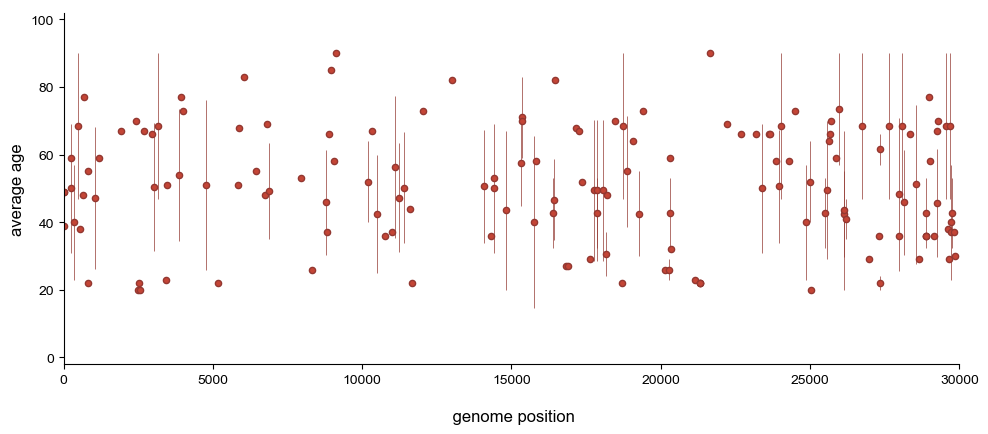

In [413]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(12,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax1 = fig.add_subplot(gs[1,0:8])

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# set fontsize of axes 
ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)

ax1.set_xlabel('\n genome position', fontname='Arial', fontsize=12)
ax1.set_ylabel('average age', fontname='Arial', fontsize=12)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-2,102)
ax1.set_xlim(-2,30000)
ax1.set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000])

ax1.errorbar(Dane_ages['Position'], Dane_ages['mean'], yerr=Dane_ages['std'], fmt='.', zorder=0, lw=0.5, c='#933831')
ax1.scatter(x=Dane_ages['Position'], y=Dane_ages['mean'], marker='o', s=20, facecolors='#C44536', edgecolors='#933831', zorder=2)

fig.savefig("../figures/SNVs_vs_age.pdf", bbox_inches='tight', dpi=300)

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

In [428]:
Dane_all = pd.concat([pd.read_csv(f, sep='\t') for f in glob.glob("../data_derived/Dane/cleaned/*.csv")], ignore_index=True)
Dane_all = Dane_all[['sample', 'Position']]

metadata_age = pd.read_csv('../data_raw/UWHC_ages.csv', sep='\t')

metadata_age = metadata_age[['strain', 'age']]

metadata_age['strain'] = metadata_age['strain'].str.replace('/','_')

metadata_age_dict = dict(zip(metadata_age.strain, metadata_age.age))

Dane_all['ages'] = Dane_all['sample'].map(metadata_age_dict)

Dane_all = Dane_all.set_index('sample')

Dane_all = Dane_all.astype(float)

Dane_all['range'] = pd.cut(Dane_all.ages,[-1,19,44,64,89,100], labels=['0-19','20-44','45-64', '65-89', '≥90'])

Dane_all.groupby('range')['ages'].count().reset_index(name='Count').to_dict(orient='records')

# age bins

# "0 - 19"	1
# "20 - 44"	56
# "45 - 64"	35
# "65 - 89"	24
# "≥ 90"	2

[{'range': '0-19', 'Count': 7},
 {'range': '20-44', 'Count': 424},
 {'range': '45-64', 'Count': 297},
 {'range': '65-89', 'Count': 183},
 {'range': '≥90', 'Count': 22}]

/Users/katbraun/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


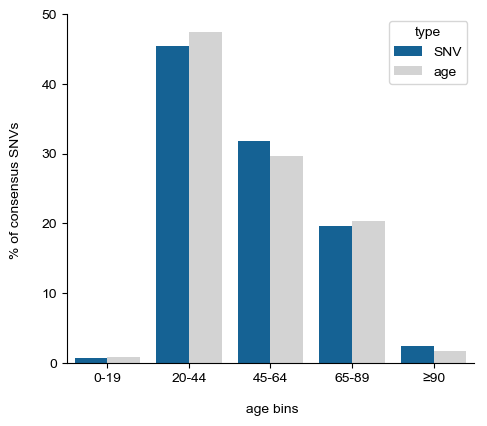

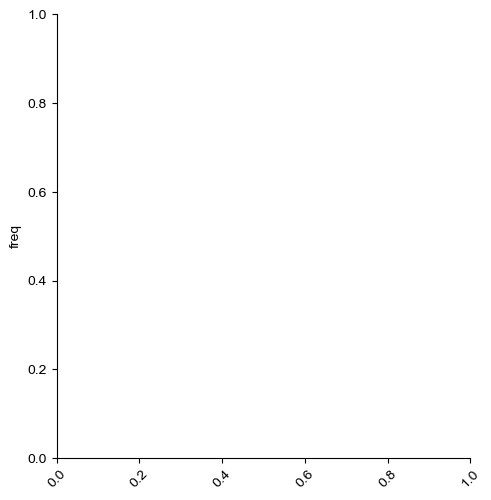

In [430]:
import seaborn as sns

# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 12)

ax3 = fig.add_subplot(gs[0,8:12]) # beta-binomial estimates 

# get right of top and right frame of each subplot
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax3.tick_params(axis = 'both', which = 'minor', labelsize = 10)


BB = pd.DataFrame({"":['0-19', '20-44', '45-64', '65-89', '≥90'], "SNV":[0.75, 45.44, 31.83, 19.61, 2.36], "age":[0.847, 47.45, 29.66, 20.34, 1.69]})
BB = pd.melt(BB, id_vars="", var_name="type", value_name="freq")

flatui = ['#0066A9', 'lightgrey', '#5BACCF', 'lightgrey', '#539648', 'lightgrey', '#C8C76F', 'lightgrey', '#E99F2E', 'lightgrey']
sns.set_palette(flatui)
sns.factorplot(x='', y='freq', data=BB, hue='type', kind='bar', ax=ax3, legend=None)

# edit the axes - ax3
ax3.set_title('', fontname='Arial', fontsize=14)
ax3.set_ylabel('% of consensus SNVs \n', fontname='Arial', fontsize=10)
ax3.set_xlabel('\n age bins', fontname='Arial', fontsize=10)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Arial")
ax3.set_ylim(0,50)
ax3.set_yticks([0,10,20,30,40,50])

plt.xticks(rotation=45)

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/SNVS-per-age-bins.pdf", bbox_inches='tight', dpi=300)
